# Assignment Week 11: midm-7B-nsmc
1. Fine-tuning [KT-AI/midm-bitext-S-7B-inst-v1](https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1) for order sentence understanding

- First 9,000 samples from the NSMC train split (for training)
- First 1,000 samples from the NSMC test split (for validation)


Dependencies required
- Setting up a Hugging Face account and obtaining authorization to use midm
- wandb for logging

2. Objective

When movie review texts are included in the prompt and input into the model, <br/>
It directly generates the prediction text as 'positive' or 'negative' <br/>

In [ ]:
pip install transformers peft accelerate optimum bitsandbytes trl wandb einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import os
from dataclasses import dataclass, field
from typing import Optional
import re

import torch
import tyro
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, LoraConfig
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

from trl import SFTTrainer

from trl.trainer import ConstantLengthDataset

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

After mounting the drive, upload files:
- food-order-understanding-small-3200.json
- food-order-understanding-small-800.json

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# /gdrive/MyDrive/Lectures/2023/nlp/food-order-understanding-small-3200.json
# /gdrive/MyDrive/Lectures/2023/nlp/food-order-understanding-small-800.json

# Setting parameters

In [ ]:
@dataclass
class ScriptArguments:
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "the cache dir"}
    )
    model_name: Optional[str] = field(
        default="midm-7b-movie-review-understanding", metadata={"help": "the model name"}
    )

    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "the dataset name"},
    )
    seq_length: Optional[int] = field(
        default=1024, metadata={"help": "the sequence length"}
    )
    num_workers: Optional[int] = field(
        default=8, metadata={"help": "the number of workers"}
    )
    training_args: TrainingArguments = field(
        default_factory=lambda: TrainingArguments(
            output_dir="./results",
            # max_steps=500,
            logging_steps=20,
            # save_steps=10,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=2,
            gradient_checkpointing=False,
            group_by_length=False,
            learning_rate=1e-4,
            lr_scheduler_type="cosine",
            # warmup_steps=100,
            warmup_ratio=0.03,
            max_grad_norm=0.3,
            weight_decay=0.05,
            save_total_limit=20,
            save_strategy="epoch",
            num_train_epochs=1,
            optim="paged_adamw_32bit",
            fp16=True,
            remove_unused_columns=False,
            report_to="wandb",
        )
    )

    packing: Optional[bool] = field(
        default=True, metadata={"help": "whether to use packing for SFTTrainer"}
    )

    peft_config: LoraConfig = field(
        default_factory=lambda: LoraConfig(
            r=8,
            lora_alpha=16,
            lora_dropout=0.05,
            target_modules=["c_attn", "c_proj", "c_fc"],
            bias="none",
            task_type="CAUSAL_LM",
        )
    )

    merge_with_final_checkpoint: Optional[bool] = field(
        default=False, metadata={"help": "Do only merge with final checkpoint"}
    )

peft_config attribute within the ScriptArguments class is configured with a LoraConfig object <br/>
LoRA, which stands for Low-Rank Adaptation, is a parameter-efficient tuning method designed to update large pre-trained models with a relatively small number of additional parameters <br/>
LoraConfig: <br/>
The configuration for LoRA tuning <br/>
LoRA aims to adapt pre-trained models for specific tasks by introducing trainable parameters that capture task-specific information <br/>
This approach allows for efficient fine-tuning of large models without modifying the original model parameters directly <br/>
r (Rank): <br/>
Specifies the rank of the low-rank matrices used in LoRA adaptation <br/>
A lower rank means fewer parameters are added, which makes the model more parameter-efficient but may limit its expressiveness <br/>
Conversely, a higher rank increases the number of parameters, potentially improving the model's ability to adapt to the new task but at the cost of increased computational resources <br/>
lora_alpha: <br/>
Controls the scale of the adaptation <br/>
It's a hyperparameter that adjusts the magnitude of updates applied through the **LoRA matrices** <br/>
lora_dropout: <br/>
Specifies the dropout rate applied to the LoRA matrices <br/>
Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training <br/>
target_modules: <br/>
A list of strings indicating which modules of the pre-trained model are to be adapted using LoRA. The values typically correspond to specific layers or components of the model architecture that are most relevant to the task at hand <br/>
For instance:
"c_attn": <br/>
Could refer to the attention calculation component, where the model decides which parts of the input to focus on <br/>
"c_proj": <br/>
Might be related to the projection layer, which maps the attention outputs to a different space <br/>
"c_fc": <br/>
Likely stands for a fully connected layer, which is a common component in neural networks for transformation and integration of learned features <br/>
bias: <br/>
Indicates how biases are handled in the LoRA adaptation <br/>
The value "none" suggests that biases are not modified as part of the LoRA process <br/>
task_type: <br/>
Specifies the type of task the model is being adapted for <br/>
"CAUSAL_LM" indicates a causal language modeling task, where the goal is to predict the next token in a sequence based on the previous tokens <br/>
Miscellaneous Settings: <br/>
Other attributes in peft_config and ScriptArguments provide additional configurations for training, such as the learning rate, batch size, number of epochs, and whether to use techniques like gradient accumulation, gradient checkpointing, and mixed-precision training (fp16) <br/>

# Utility

In [ ]:
def chars_token_ratio(dataset, tokenizer, nb_examples=400):
    """
    Estimate the average number of characters per token in the dataset.
    """
    total_characters, total_tokens = 0, 0
    for _, example in tqdm(zip(range(nb_examples), iter(dataset)), total=nb_examples):
        text = prepare_sample_text(example)
        total_characters += len(text)
        if tokenizer.is_fast:
            total_tokens += len(tokenizer(text).tokens())
        else:
            total_tokens += len(tokenizer.tokenize(text))

    return total_characters / total_tokens


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# Data Loading

In [ ]:
def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""

    prompt_template = """###System;{System}
    ###User;{User}
    ###Midm;{Midm}"""

    default_system_msg = (
        "너는 사용자가 작성한 리뷰의 긍정 또는 부정을 판단해야 한다."
    )

    text = (
        prompt_template.format(System=default_system_msg,
                               User=example["document"],
                               Midm="긍정" if example["label"]==1 else "부정"
                               )
    )

    return text

In [ ]:
def create_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    train_data = dataset['train'].select(range(9000))

    chars_per_token = chars_token_ratio(train_data, tokenizer)
    print(f"The character to token ratio of the dataset is: {chars_per_token:.2f}")

    train_dataset = ConstantLengthDataset(
        tokenizer,
        train_data,
        formatting_func=prepare_sample_text,
        infinite=True,
        seq_length=args.seq_length,
        chars_per_token=chars_per_token,
    )
    return train_dataset

In [ ]:
def create_valid_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    valid_data = dataset['test']
    valid_dataset = valid_data.select(range(1000))

    return valid_dataset

# Loading model for fine-tuning

In [ ]:
script_args = ScriptArguments(
    num_workers=2,
    seq_length=384,
    dataset_name='nsmc',
    model_name='KT-AI/midm-bitext-S-7B-inst-v1',
    )

-Google Colab virtual machine worker core can be set up to 2 cores, and up to 4 threads <br/>
-seq_length: cannot be increased much <br/>

In [ ]:
script_args.training_args.logging_steps = 100
script_args.training_args.max_steps = 200
script_args.training_args.output_dir = '/gdrive/MyDrive/nlp/lora-midm-7b-movie-review-understanding'
script_args.training_args.run_name = 'midm-7b-movie-review-understanding'

In [ ]:
print(script_args)

ScriptArguments(cache_dir=None, model_name='KT-AI/midm-bitext-S-7B-inst-v1', dataset_name='nsmc', seq_length=384, num_workers=2, training_args=TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

-The original 'KT-AI/midm-bitext-S-7B-inst-v1' provides the model in *.bin format <br/>
Problem <br/>
-A shortage of CPU memory occurs in Colab <br/>
Solution <br/>
-Decide to upload the model converted to safetensors and use it <br/>

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    script_args.model_name,
    quantization_config=bnb_config,
    device_map="auto",  # {"": Accelerator().local_process_index},
    trust_remote_code=True,
    use_auth_token=True,
    cache_dir=script_args.cache_dir,
)
base_model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

configuration_midm.py:   0%|          | 0.00/831 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- configuration_midm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_midm.py:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

rotary_position_embedding.py:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- rotary_position_embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- modeling_midm.py
- rotary_position_embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
base_model

MidmLMHeadModel(
  (transformer): MidmModel(
    (wte): Embedding(72192, 4096)
    (rotary_pos_emb): RotaryEmbedding()
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x MidmBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MidmAttention(
          (c_attn): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (c_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): MidmMLP(
          (c_fc): Linear4bit(in_features=4096, out_features=21760, bias=False)
          (c_proj): Linear4bit(in_features=10880, out_features=4096, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
 

In [ ]:
peft_config = script_args.peft_config

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'c_proj', 'c_attn', 'c_fc'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    #'KT-AI/midm-bitext-S-7B-inst-v1',
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

tokenizer.add_special_tokens(dict(bos_token='<s>'))

base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.config.bos_token_id = tokenizer.bos_token_id

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

midm_bitext_tokenization.py:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- midm_bitext_tokenization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


midm_bitext_tokenizer.model:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

bos_token: <br/>
Stands for "beginning of sequence" token <br/>
It is a special token used in many natural language processing (NLP) models to signify the start of a text sequence <br/>
When processing text, it is common to indicate where a piece of text starts and ends, and special tokens like bos_token for the start and eos_token (end of sequence) for the end are used for this purpose <br/>
BOS (Beginning Of Sequence) token, often represented as $<s>$ in various models, serves as an important marker in text sequences processed by natural language processing (NLP) models <br/>
-Sequence Initiation: <br/>
At its core, the BOS token signifies the start of a text sequence <br/>
In a straightforward application, this could mean the beginning of a sentence or paragraph <br/>
For models trained on tasks like text generation, classification, or translation, the BOS token signals where the input begins <br/>

Ref: https://gist.github.com/maldevide/0c02eac71b3755512a58eaa072914fc7 <br/>

In [ ]:
training_args = script_args.training_args

In [ ]:
train_dataset = create_datasets(tokenizer, script_args)
valid_dataset = create_valid_datasets(tokenizer, script_args)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

100%|██████████| 400/400 [00:00<00:00, 5817.36it/s]
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


The character to token ratio of the dataset is: 1.57


In [ ]:
len(train_dataset)

9000

In [ ]:
len(valid_dataset)

1000

In [ ]:
trainer = SFTTrainer(
    model=base_model,
    train_dataset=train_dataset,
    eval_dataset=None,
    peft_config=peft_config,
    packing=script_args.packing,
    max_seq_length=script_args.seq_length,
    tokenizer=tokenizer,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
base_model

In [ ]:
base_model.device

device(type='cuda', index=0)

In [ ]:
print_trainable_parameters(base_model)

trainable params: 16744448 || all params: 3821510656 || trainable%: 0.4381630592527648


Features when applying the midm model to order sentence understanding: <br/>
-During the model loading process, CPU uses 5.1 GB, disk space 42.4 GB, GPU memory: 7.4 GB <br/>

Google Colab T-4 GPU: 300 steps (expected 13:47 minutes)

For sequence length of 384: <br/>
-Uses 14.7 GB / 15.0 GB <br/>
-Reduce from this if memory overflow occurs <br/>


In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,1.244500
200,1.057000


TrainOutput(global_step=200, training_loss=1.150794563293457, metrics={'train_runtime': 230.4337, 'train_samples_per_second': 1.736, 'train_steps_per_second': 0.868, 'total_flos': 6210338999500800.0, 'train_loss': 1.150794563293457, 'epoch': 0.04})

**trainer.train()**: <br/>
Initiates the training process using the configuration provided to the SFTTrainer instance <br/>
The model will learn from train_dataset according to the specifications in peft_config, training_args, and other parameters <br/>

In [ ]:
script_args.training_args.output_dir

'/gdrive/MyDrive/nlp/lora-midm-7b-movie-review-understanding'

In [ ]:
trainer.save_model(script_args.training_args.output_dir)

# Inference Test

In [ ]:
from transformers import pipeline, TextStreamer

In [ ]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
      "너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 주어진 영화 리뷰에 대한 긍정 또는 부정을 추출해야 한다."
)

In [ ]:
def wrapper_generate(model, input_prompt, do_stream=False):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            input_ids=input_ids.cuda(),
            streamer=streamer if do_stream else None,
            use_cache=True,
            max_new_tokens=float('inf'),
            do_sample=False
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    decoded_text = decoded_text[0].replace("<[!newline]>", "\n")
    return (decoded_text[len(input_prompt):])

In [ ]:
eval_dic1 = {i:wrapper_generate(model=base_model, input_prompt=prompt_template.format(System=default_system_msg, User=query["document"]))for i, query in enumerate(valid_dataset)}

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [ ]:
print(eval_dic1[0])

긍정


# Test after loading fine-tuned model

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    script_args.training_args.output_dir,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir=script_args.cache_dir
)

The repository for KT-AI/midm-bitext-S-7B-inst-v1 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/KT-AI/midm-bitext-S-7B-inst-v1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
tokenizer.add_special_tokens(dict(bos_token='<s>'))
trained_model.config.pad_token_id = tokenizer.pad_token_id
trained_model.config.bos_token_id = tokenizer.bos_token_id

**Adding Special Tokens** <br/>
Adding BOS Token: <br/>
tokenizer.add_special_tokens(dict(bos_token='$<s>$')): <br/>
Adds a new special token $<s>$ as the beginning-of-sequence (BOS) token <br/>
The BOS token is used to indicate the start of a text sequence, which can be critical for certain types of models, especially those involved in generative tasks <br/>
**Model Configuration Update**  <br/>
Updating Model Configuration for Padding and BOS Tokens: <br/>
The model's configuration is updated to recognize the IDs of the newly set pad_token and bos_token. <br/>
This ensures that the model can correctly interpret and handle these special tokens during training and inference. <br/>
trained_model.config.pad_token_id = tokenizer.pad_token_id: <br/>
Sets the model's padding token ID to match the tokenizer's padding token ID.
trained_model.config.bos_token_id = tokenizer.bos_token_id: <br/>
Sets the model's beginning-of-sequence token ID to match the tokenizer's BOS token ID.

During the inference process, about 5.5 GB of GPU memory is utilized <br/>

In [ ]:
eval_dic2 = {i:wrapper_generate(model=trained_model, input_prompt=prompt_template.format(System=default_system_msg, User=query["document"]))for i, query in enumerate(valid_dataset)}

In [ ]:
print(eval_dic2[0])

긍정


# Classification results for test data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_models_performance(true_labels, predicted_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    plt.show()


## Base Model Performance

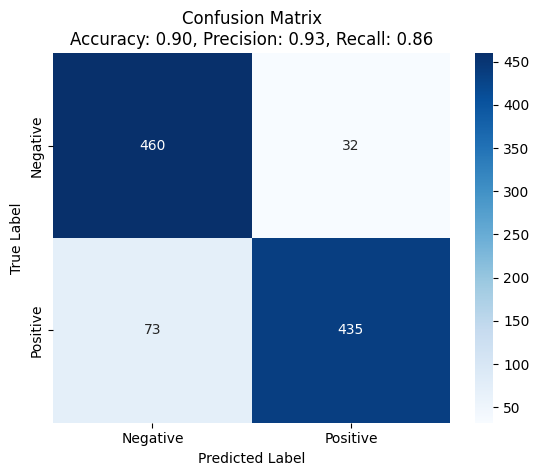

In [ ]:
# Base Model Performance
true_labels = [example["label"] for example in valid_dataset]
predicted_labels = [1 if "긍정" in eval_dic1[i] else 0 for i in range(len(valid_dataset))]
evaluate_models_performance(true_labels, predicted_labels)

## PEFT Model Performance

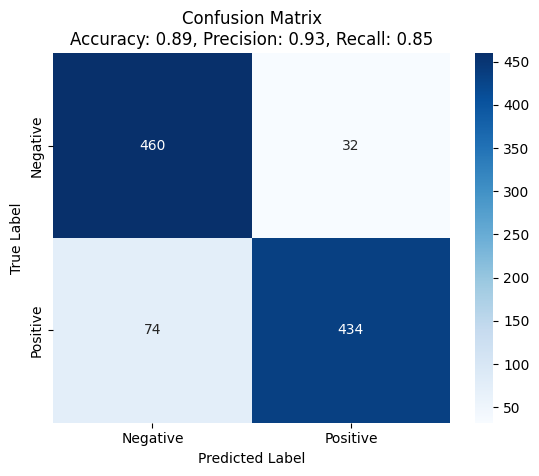

In [ ]:
# PEFT Model Performance
true_labels = [example["label"] for example in valid_dataset]
predicted_labels = [1 if "긍정" in eval_dic2[i] else 0 for i in range(len(valid_dataset))]
evaluate_models_performance(true_labels, predicted_labels)

결론: <br/>
base_model하고 peft_model 큰 성능 차이 없음 <br/>

Peft Model Results <br/>
Accuracy:0.89 <br/>
Demonstrates high accuracy, correctly predicting 89.0% of the cases.<br/>
Precision: 0.93 <br/>
Among the cases the model predicted as positive, 77% were actually positive. This indicates the model is good at identifying true positives and avoids false positives.<br/>
Recall: 0.85 <br/>
The model correctly identified 88% of the actual positive cases. Model is good at capturing most of the relevant positive cases and minimizes false negatives.<br/>

#Upload the fine-tuned adapter to Hugging Face Hub & include the uploaded ID in the notebook

https://huggingface.co/growingpenguin/hw-midm-7B-nsmc/tree/main